# Evaluation metrics

## Import data_utils

In [1]:
from climsim_utils.data_utils import *

2023-08-21 14:36:29.941637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 14:36:30.922437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Instantiate class

In [2]:
grid_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'
norm_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale)

## Load data and set pressure grid

In [48]:
# paths to scoring data
input_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy'
target_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy'

# paths to model predictions
cvae_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/cVAE/cvae_preds_manual.h5'
ed_pred_path = '/ocean/projects/atm200007p/behrens/ED_Behrens_2022/ED_ClimSIM_1_3_pred.npy'
hsr_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/HSR/hsr_preds_bestcrps.h5'
rpn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/rpn_pred_v1_stride6.npy'
cnn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/val_predict_cnn_reshaped_stride6_FINAL.npy'
mlp_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy'

# set variables to V1 subset
data.set_to_v1_vars()

# path to target input
data.input_scoring = np.load(input_path)

# path to target output
data.target_scoring = np.load(target_path)

# set pressure weights
data.set_pressure_grid(input_arr = data.input_scoring)

# load model predictions
data.model_names = ['CNN','cVAE','ED','HSR','MLP', 'RPN']
preds = [data.load_npy_file(load_path = cnn_pred_path), 
         data.load_h5_file(load_path = cvae_pred_path),
         data.load_npy_file(load_path = ed_pred_path), 
         data.load_h5_file(load_path = hsr_pred_path), 
         data.load_npy_file(load_path = mlp_pred_path), 
         data.load_npy_file(load_path = rpn_pred_path)]
data.preds_scoring = dict(zip(data.model_names, preds))

## Weight outputs

1. Undo output scaling

2.  Weight vertical levels by dp/g

3. Weight horizontal area of each grid cell by a[x]/mean(a[x])

4. Convert units to a common energy unit

In [49]:
data.reweight_target(data_split = 'scoring')
data.reweight_preds(data_split = 'scoring')

data.metrics_names = ['MAE', 'RMSE', 'R2']
data.create_metrics_df(data_split = 'scoring')

/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:649: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:649: RuntimeWarning: invalid value encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:649: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:649: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:649: RuntimeWarning: divide by zero en

## Create plots

In [50]:
%config InlineBackend.figure_format = 'retina'
letters = string.ascii_lowercase

In [51]:
dict_idx = data.metrics_var_scoring
dict_var = data.metrics_idx_scoring

plot_df_byvar = {}
for metric in data.metrics_names:
    plot_df_byvar[metric] = pd.DataFrame([dict_idx[model][metric] for model in data.model_names],
                                               index=data.model_names)
    plot_df_byvar[metric] = plot_df_byvar[metric].rename(columns = data.var_short_names).transpose()

In [54]:
plot_df_byvar

{'MAE':                 CNN       cVAE         ED        HSR        MLP        RPN
 variable                                                                  
 $dT/dt$    2.585418   2.732051   2.864516   2.844789   2.682765   2.685253
 $d1/dt$    4.400639   4.679666   4.673036   4.784426   4.494752   4.592410
 NETSW     18.845029  19.729191  14.967681  19.816967  13.360914  18.878685
 FLWDS      8.597703   6.588051   6.893821   6.266635   5.224468   6.017693
 PRECSC     3.364180   3.321645   3.045900   3.511187   2.683915   3.328444
 PRECC     37.825799  38.805963  37.250200  42.379195  34.333065  37.455143
 SOLS      10.830984  10.939536   8.553734  11.314418   7.970805  10.355971
 SOLL      13.152971  13.461330  10.923703  13.602788  10.299178  12.955313
 SOLSD      5.816831   6.158717   5.074686   6.330680   4.533141   5.845594
 SOLLD      5.678992   6.065650   5.136236   6.214983   4.806307   5.701871,
 'RMSE':                 CNN       cVAE         ED        HSR        MLP        

In [53]:
dict_idx

{'CNN':                       MAE       RMSE        R2
 variable                                      
 ptend_t          2.585418   4.369106   0.62726
 ptend_q0001      4.400639   7.283705      -inf
 cam_out_NETSW   18.845029  36.906747    0.9438
 cam_out_FLWDS    8.597703  10.854747  0.827836
 cam_out_PRECSC    3.36418   6.000881       NaN
 cam_out_PRECC   37.825799  85.311686   0.07693
 cam_out_SOLS    10.830984  22.916411  0.927029
 cam_out_SOLL    13.152971  27.251214  0.915685
 cam_out_SOLSD    5.816831  12.126842  0.927229
 cam_out_SOLLD    5.678992  12.102328  0.812537,
 'cVAE':                       MAE       RMSE        R2
 variable                                      
 ptend_t          2.732051   4.720812  0.589693
 ptend_q0001      4.679666   7.779619      -inf
 cam_out_NETSW   19.729191  38.364034  0.956531
 cam_out_FLWDS    6.588051   8.529763  0.883237
 cam_out_PRECSC   3.321645   6.182026      -inf
 cam_out_PRECC   38.805963  88.711142 -0.926289
 cam_out_SOLS    10.9395

### Plot 1

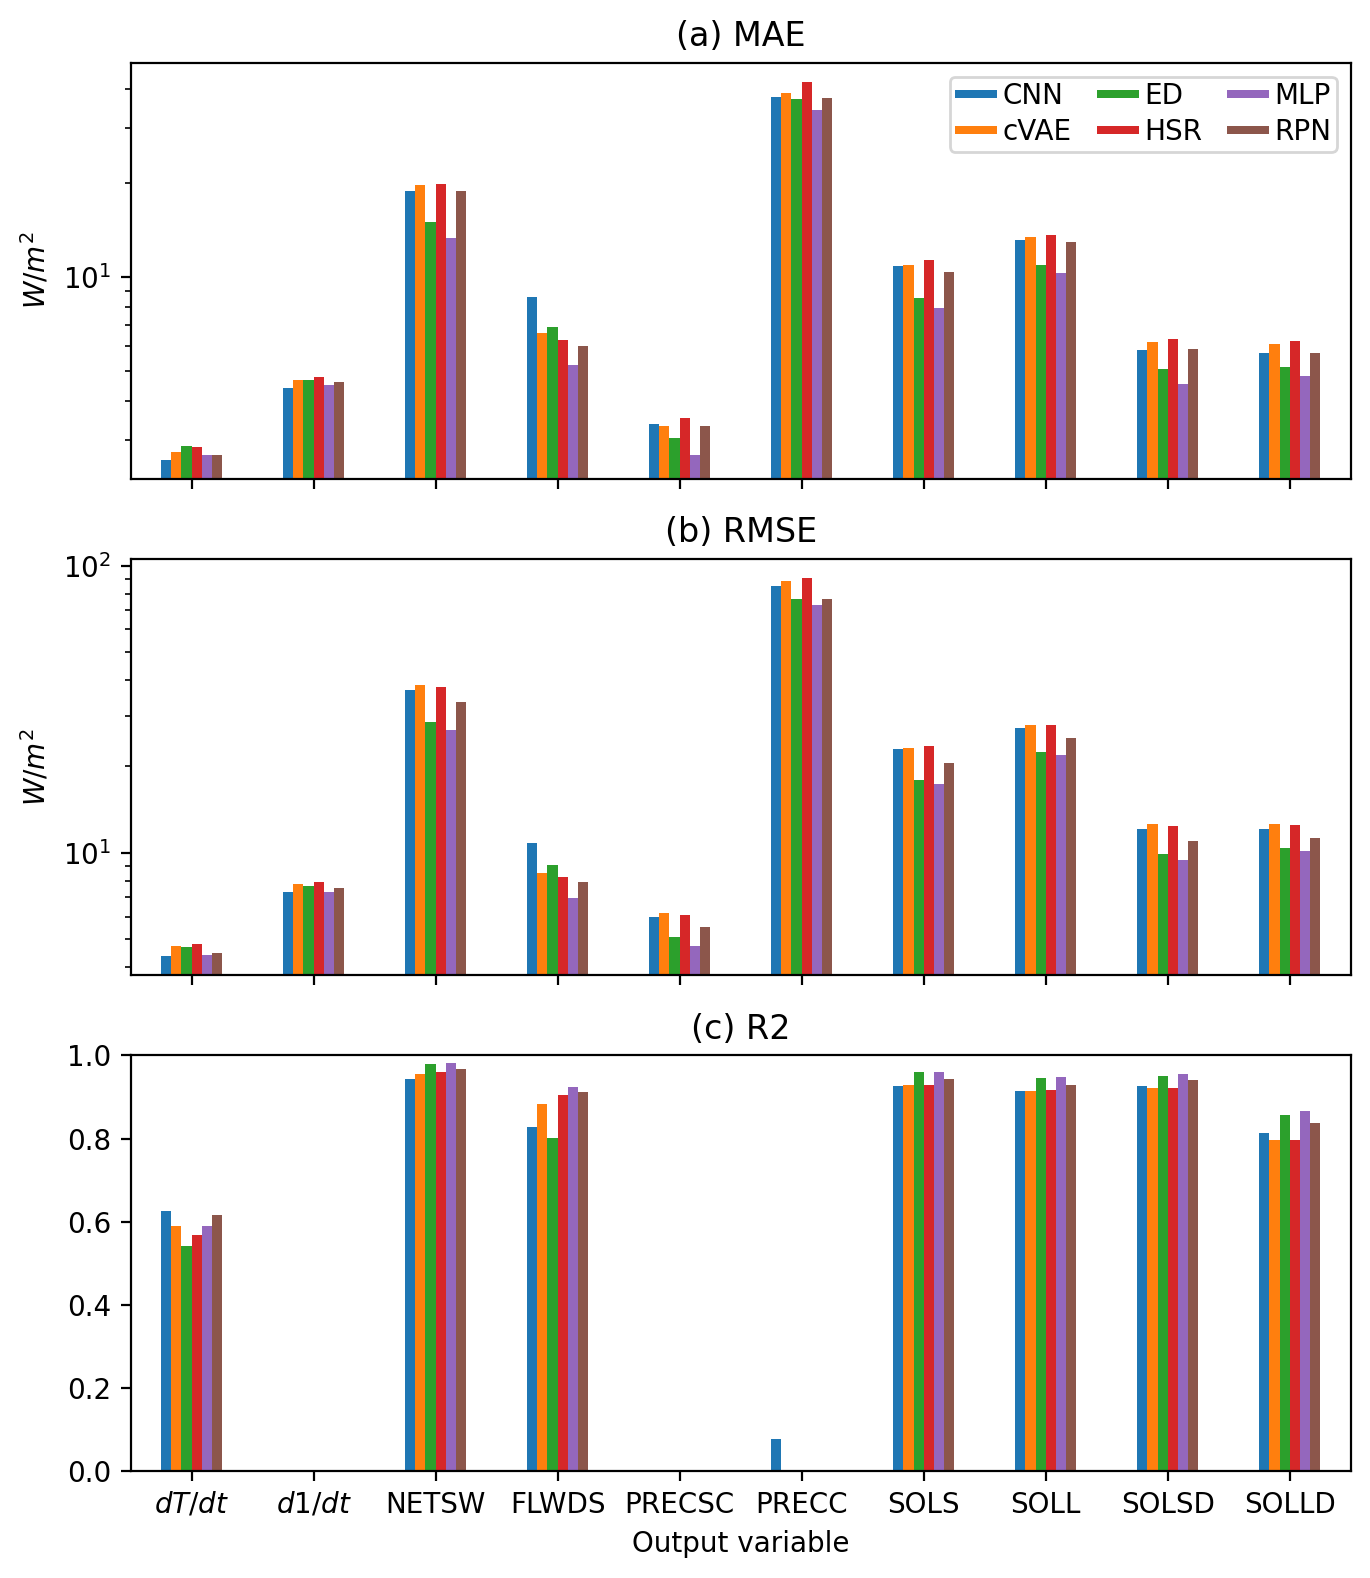

In [52]:
fig, axes = plt.subplots(nrows  = len(data.metrics_names), sharex = True)
for i in range(len(data.metrics_names)):
    plot_df_byvar[data.metrics_names[i]].plot.bar(
        legend = False,
        ax = axes[i])
    if data.metrics_names[i] != 'R2':
        axes[i].set_ylabel('$W/m^2$')
        axes[i].set_yscale('log')
    else:
        axes[i].set_ylim(0,1)

    axes[i].set_title(f'({letters[i]}) {data.metrics_names[i]}')
axes[i].set_xlabel('Output variable')
axes[i].set_xticklabels(plot_df_byvar[data.metrics_names[i]].index, \
    rotation=0, ha='center')

axes[0].legend(columnspacing = .9, 
               labelspacing = .3,
               handleheight = .07,
               handlelength = 1.5,
               handletextpad = .2,
               borderpad = .2,
               ncol = 3,
               loc = 'upper right')
fig.set_size_inches(7,8)
fig.tight_layout()

In [44]:
hmm = data.load_npy_file(load_path = '/ocean/projects/atm200007p/behrens/ED_Behrens_2022/ED_ClimSIM_1_3_pred.npy')

In [46]:
hmm.shape

(1681920, 128)

In [47]:
data.target_scoring.shape

(1681920, 128)

In [33]:
import matplotlib
print(matplotlib.__version__)

3.5.2


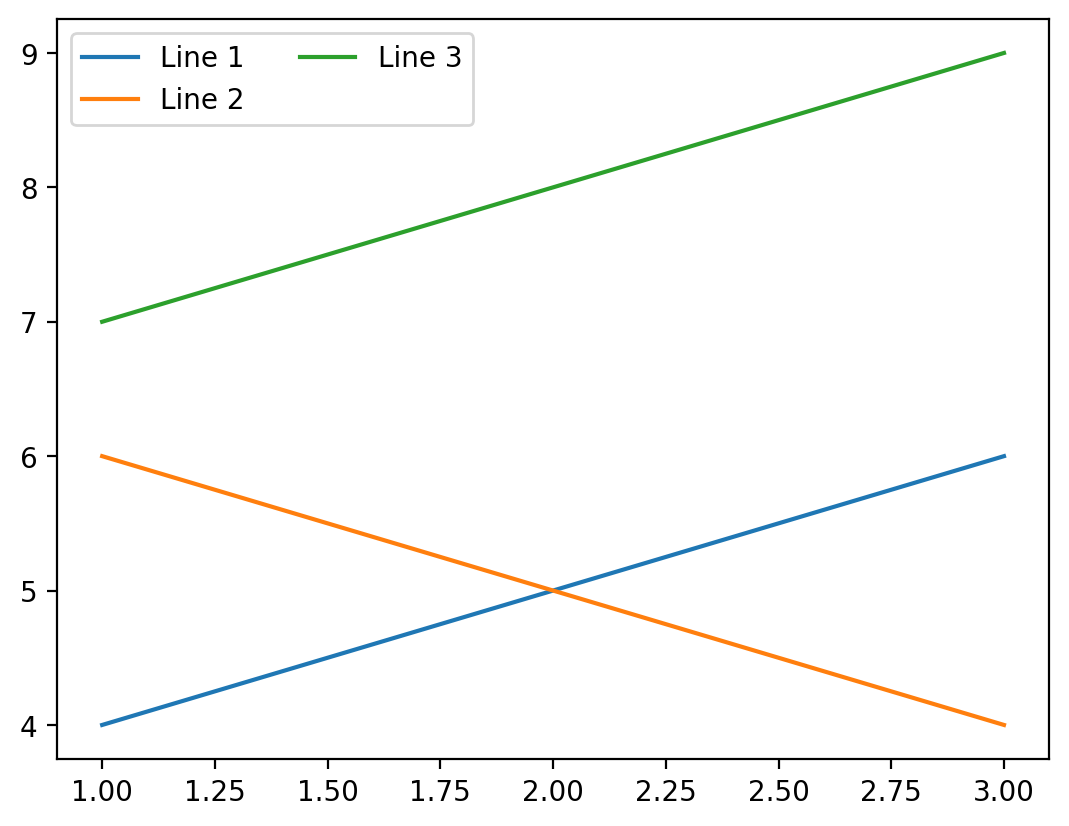

In [32]:
fig, ax = plt.subplots()
ax.plot([1, 2, 3], [4, 5, 6], label='Line 1')
ax.plot([1, 2, 3], [6, 5, 4], label='Line 2')
ax.plot([1, 2, 3], [7, 8, 9], label='Line 3')
ax.legend()

# set the number of columns in the legend to 2
ax.legend(ncol=2)

# show the plot
plt.show()

### Plot 2

### Plot 3

### Plot 4